In [1]:
#@title Download L5 Sample Dataset and install L5Kit
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
    !sh ./setup_notebook_colab.sh
    os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
else:
    os.environ["L5KIT_DATA_FOLDER"] = "/tmp/l5kit_data"
    print("Not running in Google Colab.")

sample.tar          100%[===================>]  51.37M  23.3MB/s    in 2.2s    
semantic_map.tar    100%[===================>]   2.86M  4.34MB/s    in 0.7s    
aerial_map.tar      100%[===================>]   2.28G  35.4MB/s    in 67s     
Installing L5kit...







Dataset and L5kit are ready !


In [2]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ead4977168d0b7af22cca4205190f39759ef70ac06e74bdf90a48e81ace1511f
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [75]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from tqdm import tqdm
from torchvision import transforms

from efficientnet_pytorch import EfficientNet
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.rasterization import BoxRasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable
import matplotlib.pyplot as plt

import numpy as np
import os

from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

In [14]:
MODEL = 'efficientnetv2-b0'  #@param



In [15]:
dm = LocalDataManager(None)
cfg = load_config_data("/content/agent_motionconfig.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'efficientnetv2-b0', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [77]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


getting centroid to plot trajectory: 100%|██████████| 24838/24838 [00:27<00:00, 902.82it/s]


(-2500.0, 1600.0)

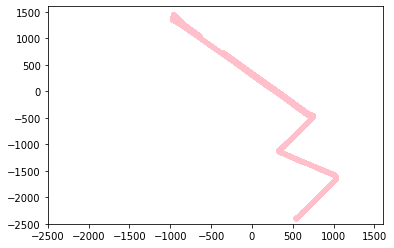

In [82]:
frames = zarr_dataset.frames
coords = np.zeros((len(frames), 2))
for idx_coord, idx_data in enumerate(tqdm(range(len(frames)), desc="getting centroid to plot trajectory")):
    frame = zarr_dataset.frames[idx_data]
    coords[idx_coord] = frame["ego_translation"][:2]


plt.scatter(coords[:, 0], coords[:, 1], marker='.', c="pink")
axes = plt.gca()
axes.set_xlim([-2500, 1600])
axes.set_ylim([-2500, 1600])

## Model

Our baseline is a simple `resnet50` pretrained on `imagenet`. We must replace the input and the final layer to address our requirements.

In [16]:
model = EfficientNet.from_pretrained('efficientnet-b0')
#!git clone https://github.com/sathyapriyaa-sketch/EfficientNet-PyTorch
print(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dS

In [17]:

import tensorflow.compat.v1 as tf
print(tf.__version__)


2.5.0


In [18]:
def build_model(cfg: Dict) -> torch.nn.Module:
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
   
   
    
    
    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels

    print(num_in_channels)
    model.from_pretrained = nn.Conv2d(num_in_channels,model._conv_stem.out_channels,
        kernel_size=model._conv_stem.kernel_size,stride=model._conv_stem.stride,
        padding=model._conv_stem.padding,
        bias=False,
    )
    print("Output channels", model._conv_stem.out_channels)
    #change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    #print(model_fc.in_features)
    model ._fc= torch.nn.Linear(in_features=1280, out_features=num_targets, bias=True)
    print(model._fc.in_features)
    print(type(model._fc.in_features))
    #model.fc = nn.Linear(in_features=50176, out_features=num_targets)
    #output = model(input)
    #print(output.shape)
    #model.fc = nn.Linear(in_features=1200, out_features=100)
    
    return model

In [57]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    inputs.resize_([12, 3, 224, 224])
    
    #inputs = inputs.view(12, -1)
    print("input",inputs.size())
    print(type(input))
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
  


    targets = data["target_positions"].to(device)
    #targets = data["target_positions"].unsqueeze(-1).to(device)
    print("target",targets.size())
    print(type(targets))
    # Forward pass
    #outputs = model(inputs)
    outputs = model(inputs).reshape(targets.shape)
    #x = x.view(-1, 12*224*224)
    #x = x.unsqueeze(1)
    #print ("model size", x.size())
   # print(model.eval())
  
 #   outputs = model(inputs).reshape([12, 1000])
   # targets = model(targets).reshape([12, 1000])
    
    print("outputs in forward",outputs.size())
  #  print(outputs.size())
    import math
    from math import sqrt
    #loss = mean_squared_error(outputs, targets)
    loss = criterion(outputs, targets)
    print(loss)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

In [54]:
# ===== INIT DATASET
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(type(train_dataloader))
scene_idx = 1
indexes = train_dataset.get_scene_indices(scene_idx)
images = []
train_img_updated = []
for idx in indexes:
    data = train_dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = train_dataset.rasterizer.to_rgb(im)
    train_img_updated.append(im)
   
   
    target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
   # d1 = DataLoader( train_img_updated, batch_size=3)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                            num_workers=train_cfg["num_workers"])
print(type(train_dataloader))


  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


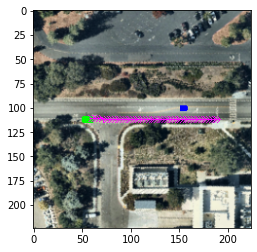

In [83]:
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
data = dataset[50]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im)
plt.show()

In [55]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")

5
Output channels 32
1280
<class 'int'>


In [58]:
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
for _ in progress_bar:
    try:
        data = next(tr_it)
               
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model = model.train()
   
    torch.set_grad_enabled(True)
   # print(model)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  0%|          | 0/5 [00:00<?, ?it/s]

input torch.Size([12, 3, 224, 224])
<class 'method'>
target torch.Size([12, 50, 2])
<class 'torch.Tensor'>
outputs in forward torch.Size([12, 50, 2])
tensor([[[3.1594e-01, 1.5134e-03],
         [6.2594e-01, 5.9784e-03],
         [7.6359e-01, 2.2671e-03],
         ...,
         [4.0160e+01, 4.1866e-02],
         [4.3976e+01, 3.9537e-01],
         [4.8522e+01, 3.4782e-01]],

        [[3.1330e-02, 2.4440e-02],
         [9.2168e-01, 7.6704e-04],
         [1.0720e+00, 1.2782e-03],
         ...,
         [5.9942e-02, 3.7042e-02],
         [3.0788e-01, 2.4350e-01],
         [2.5077e-02, 2.3199e-02]],

        [[2.4646e-02, 2.4618e-02],
         [9.3111e-02, 2.8411e-02],
         [5.9935e-02, 8.0923e-02],
         ...,
         [2.0034e-01, 2.7599e-03],
         [1.9674e-01, 2.3586e-02],
         [1.2910e-01, 2.1881e-01]],

        ...,

        [[1.6989e-02, 2.2682e-02],
         [3.6848e-02, 3.9836e-02],
         [4.1296e-02, 5.0400e-03],
         ...,
         [1.2224e+02, 1.5732e-02],
    

loss: 30.2934627532959 loss(avg): 30.2934627532959:  20%|██        | 1/5 [00:24<01:39, 24.91s/it]

input torch.Size([12, 3, 224, 224])
<class 'method'>
target torch.Size([12, 50, 2])
<class 'torch.Tensor'>
outputs in forward torch.Size([12, 50, 2])
tensor([[[2.2618e-03, 1.9268e-01],
         [6.2333e-02, 1.2526e-01],
         [1.2565e-02, 1.6700e-02],
         ...,
         [2.8408e-04, 1.6528e-02],
         [7.1364e-02, 3.6423e-02],
         [2.9167e-04, 1.7931e-03]],

        [[2.4376e+00, 5.8154e-03],
         [1.4503e+01, 2.0993e-04],
         [3.3657e+01, 9.5815e-02],
         ...,
         [7.4430e-02, 3.0504e-05],
         [8.9736e-02, 1.7968e-02],
         [1.2774e-01, 4.3042e-04]],

        [[1.0539e-07, 1.8065e-01],
         [1.2785e-01, 1.6055e-02],
         [3.5216e-02, 3.3658e-02],
         ...,
         [2.1810e-01, 4.6049e-02],
         [2.9149e-02, 1.3755e-02],
         [3.7641e-02, 2.8018e-02]],

        ...,

        [[5.1432e-03, 3.3968e-03],
         [1.9499e-03, 3.8061e-02],
         [3.8572e-03, 5.0280e-03],
         ...,
         [1.1799e-01, 8.2794e-03],
    

loss: 125.25630187988281 loss(avg): 77.77488231658936:  40%|████      | 2/5 [00:29<00:38, 12.72s/it]

input torch.Size([12, 3, 224, 224])
<class 'method'>
target torch.Size([12, 50, 2])
<class 'torch.Tensor'>
outputs in forward torch.Size([12, 50, 2])
tensor([[[9.7645e-02, 2.9459e-02],
         [3.9802e-02, 4.3323e-03],
         [1.6816e+00, 2.2233e-01],
         ...,
         [1.0601e+03, 7.2236e+02],
         [1.1336e+03, 7.9310e+02],
         [1.1908e+03, 8.3263e+02]],

        [[2.7391e-01, 2.1953e-02],
         [2.4775e-02, 2.9362e-03],
         [5.5180e-01, 6.3429e-02],
         ...,
         [3.2299e-02, 1.0398e-03],
         [2.3254e-03, 7.2812e-02],
         [1.4356e-01, 1.1830e-03]],

        [[6.0102e-03, 3.8146e-02],
         [9.4996e-03, 2.7744e-02],
         [6.4061e-03, 4.5560e-03],
         ...,
         [1.3122e-01, 5.7307e-03],
         [9.1559e-03, 1.8884e-05],
         [3.3536e-01, 1.3181e-02]],

        ...,

        [[1.1266e-01, 7.6796e-02],
         [5.5086e-03, 1.3356e-03],
         [4.6388e-03, 5.1253e-03],
         ...,
         [5.8942e-02, 2.2319e-03],
    

loss: 53.940521240234375 loss(avg): 69.8300952911377:  60%|██████    | 3/5 [00:33<00:17,  8.81s/it]

input torch.Size([12, 3, 224, 224])
<class 'method'>
target torch.Size([12, 50, 2])
<class 'torch.Tensor'>
outputs in forward torch.Size([12, 50, 2])
tensor([[[1.0089e-02, 7.7359e-02],
         [6.7724e-02, 3.5262e-03],
         [4.7148e-04, 3.4021e-03],
         ...,
         [1.0915e+00, 2.2342e-03],
         [6.3582e-01, 1.0077e-01],
         [1.0110e+00, 1.4964e-01]],

        [[1.8360e+00, 1.6975e-03],
         [8.3369e+00, 4.2834e-03],
         [1.8900e+01, 1.4639e-01],
         ...,
         [4.9041e+03, 3.2016e+00],
         [5.1317e+03, 2.9493e+00],
         [5.3668e+03, 2.1412e+00]],

        [[9.1799e-03, 5.4483e-03],
         [1.1199e-02, 2.0055e-02],
         [3.0218e-02, 1.4022e-01],
         ...,
         [1.4842e-02, 2.7590e-03],
         [5.4853e-02, 5.0656e-02],
         [4.2997e-02, 1.3709e-02]],

        ...,

        [[6.7581e-01, 2.3028e-02],
         [3.2938e+00, 2.2441e-02],
         [8.9538e+00, 1.3332e-03],
         ...,
         [3.3749e+03, 9.4664e+00],
    

loss: 246.31903076171875 loss(avg): 113.95232915878296:  80%|████████  | 4/5 [00:37<00:07,  7.01s/it]

input torch.Size([12, 3, 224, 224])
<class 'method'>
target torch.Size([12, 50, 2])
<class 'torch.Tensor'>
outputs in forward torch.Size([12, 50, 2])
tensor([[[1.0626e-01, 4.0197e-02],
         [1.9104e-03, 1.6301e-02],
         [2.7678e-02, 2.1981e-02],
         ...,
         [4.3058e+00, 2.7602e-04],
         [3.6451e+00, 3.2395e-02],
         [2.6472e+00, 3.3736e-02]],

        [[1.7372e-01, 4.0494e-02],
         [3.7633e-02, 1.1298e-02],
         [1.4705e-02, 1.6650e-02],
         ...,
         [1.3751e-01, 6.0291e-02],
         [1.8649e-02, 1.1462e-02],
         [3.1518e-01, 2.1835e-02]],

        [[1.9424e-02, 4.0082e-03],
         [2.2290e-01, 9.3042e-03],
         [1.3710e-01, 2.5292e-02],
         ...,
         [2.7584e-01, 3.5333e-03],
         [9.9638e-02, 4.7652e-02],
         [4.9829e-02, 6.4339e-02]],

        ...,

        [[1.3448e-01, 3.1622e-03],
         [6.6396e-01, 7.6192e-05],
         [5.3814e-01, 1.4618e-01],
         ...,
         [7.9145e-01, 1.6193e-01],
    

loss: 127.55564880371094 loss(avg): 116.67299308776856: 100%|██████████| 5/5 [00:41<00:00,  8.34s/it]


# Training

note: if you're on MacOS and using `py_satellite` rasterizer, you may need to disable opencv multiprocessing by adding:
`cv2.setNumThreads(0)` before the following cell. This seems to only affect running in python notebook and it's caused by the `cv2.warpaffine` function

### Plot Loss Curve
We can plot the train loss against the iterations (batch-wise)

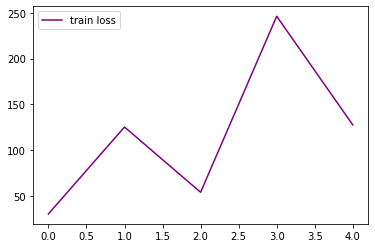

In [70]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss", c="purple")
plt.legend()
plt.show()

In [74]:
num_frames_to_chop = 100
eval_cfg = cfg["val_data_loader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)
    

copying: 100%|██████████| 100/100 [00:02<00:00, 39.63it/s]
/usr/local/lib/python3.7/dist-packages/l5kit/evaluation/extract_ground_truth.py:52: RuntimeWarning:

you're running with a custom agents_mask

extracting GT: 100%|██████████| 480/480 [00:06<00:00, 69.14it/s]


TypeError: ignored

In [25]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
rasterizer = build_rasterizer(cfg, dm)
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: you're running with a custom agents_mask
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = transform_points(agents_coords, world_from_agents) - centroids[:, None, :2]
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


input torch.Size([12, 3, 224, 224])
<class 'method'>
target torch.Size([12, 50, 2])
<class 'torch.Tensor'>


  2%|▎         | 1/40 [00:20<13:33, 20.87s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.5923e-01, 1.8720e-02],
         [7.2458e-05, 8.4556e-02],
         [6.5025e-03, 1.0795e-01],
         ...,
         [1.4882e-03, 2.0633e-03],
         [4.5854e-04, 7.0537e-05],
         [1.4495e-03, 1.3030e-02]],

        [[4.2031e-01, 4.8369e-05],
         [1.5357e-02, 2.4843e-01],
         [1.0228e-01, 5.6870e-06],
         ...,
         [1.7379e-02, 3.8376e-02],
         [1.9897e-02, 3.9786e-02],
         [1.2743e-02, 2.7528e-03]],

        [[2.7014e-01, 4.5391e-02],
         [8.9800e-02, 7.5744e-02],
         [8.7582e-02, 4.1314e-02],
         ...,
         [4.9503e-03, 6.1057e-03],
         [1.7407e-02, 1.6602e-03],
         [1.3534e-01, 7.2399e-04]],

        ...,

        [[3.0342e-01, 1.7727e-02],
         [2.9863e-01, 6.5381e-02],
         [8.8168e-02, 8.8893e-02],
         ...,
         [1.6587e-02, 5.0110e-03],
         [2.5533e-03, 4.4918e-02],
         [4.7954e-02, 1.2305e-02]],

        [[6.7341e-02, 1.3831e-02],
    

  5%|▌         | 2/40 [00:22<05:56,  9.39s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[4.0973e-03, 1.0123e-02],
         [1.1394e-01, 6.7295e-03],
         [8.3355e-02, 1.7354e-02],
         ...,
         [2.5194e-03, 1.2130e-04],
         [1.5535e-02, 1.5483e-04],
         [1.3862e-03, 4.7358e-03]],

        [[1.0893e-01, 8.8307e-05],
         [5.2076e-02, 4.8573e-04],
         [2.4928e-02, 1.3052e-02],
         ...,
         [7.9056e-04, 2.2994e-02],
         [9.9942e-04, 2.6805e-03],
         [1.6758e-01, 5.5367e-03]],

        [[1.1274e-02, 9.8687e-03],
         [4.1848e-02, 4.5837e-02],
         [6.1996e-02, 1.6794e-02],
         ...,
         [3.4153e-03, 4.5228e-02],
         [5.9259e-02, 8.5231e-02],
         [3.3333e-05, 2.3741e-03]],

        ...,

        [[1.5264e-01, 2.6048e-02],
         [6.8494e-03, 1.6022e-01],
         [5.2489e-02, 3.8744e-02],
         ...,
         [1.5342e-02, 1.1635e-03],
         [4.0208e-02, 8.0638e-03],
         [2.5355e-02, 7.4049e-02]],

        [[2.9833e-04, 1.7498e-03],
    

  8%|▊         | 3/40 [00:23<03:29,  5.65s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[3.7312e-02, 1.5162e-02],
         [1.1580e-02, 1.1147e-01],
         [7.0136e-03, 9.9703e-03],
         ...,
         [2.2448e-05, 2.9616e-02],
         [1.8274e-02, 1.2125e-03],
         [4.0787e-02, 1.5073e-02]],

        [[3.4896e-01, 3.3253e-02],
         [2.8390e-02, 2.2319e-01],
         [2.1284e-01, 2.0775e-02],
         ...,
         [1.3809e-03, 3.3923e-03],
         [1.0445e-01, 1.2584e-02],
         [4.0601e-01, 5.0483e-02]],

        [[8.5397e-02, 1.6968e-02],
         [1.5106e-03, 1.9135e-01],
         [1.2608e-01, 1.3775e-04],
         ...,
         [5.6295e-02, 3.0710e-02],
         [1.3737e-01, 4.4938e-02],
         [1.2643e-01, 1.1894e-02]],

        ...,

        [[5.7152e-02, 6.4848e-05],
         [5.0012e-02, 1.3040e-02],
         [1.8029e-03, 3.4687e-03],
         ...,
         [2.3695e-03, 1.0413e-02],
         [9.2744e-02, 2.2568e-03],
         [2.1962e-02, 2.8751e-02]],

        [[7.7279e-04, 1.1342e-02],
    

 10%|█         | 4/40 [00:24<02:19,  3.87s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[2.6391e-01, 1.1557e-02],
         [1.1510e-02, 1.9565e-01],
         [1.3543e-02, 2.7905e-03],
         ...,
         [1.1157e-02, 4.2374e-02],
         [7.5165e-02, 1.2061e-03],
         [1.1349e-01, 4.8656e-02]],

        [[5.0634e-01, 4.1106e-02],
         [1.1999e-02, 7.2151e-02],
         [1.5161e-01, 2.6033e-03],
         ...,
         [8.3075e-02, 2.7985e-02],
         [2.0797e-01, 5.9283e-02],
         [1.1624e-01, 3.5607e-02]],

        [[2.4786e-01, 1.1953e-01],
         [1.0305e-02, 4.2311e-02],
         [3.0975e-01, 4.4541e-03],
         ...,
         [1.4999e-07, 1.0374e-02],
         [1.2733e-01, 6.2821e-04],
         [1.5903e-01, 3.3612e-02]],

        ...,

        [[3.3359e-01, 4.9245e-02],
         [1.1684e-02, 5.1458e-02],
         [4.7454e-01, 5.3590e-03],
         ...,
         [5.4674e-02, 4.2746e-02],
         [1.7371e-01, 8.0824e-03],
         [2.2660e-01, 4.0792e-02]],

        [[2.2133e-01, 1.3384e-02],
    

 12%|█▎        | 5/40 [00:25<01:41,  2.90s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[2.2169e-01, 7.7936e-03],
         [3.8381e-05, 8.9137e-02],
         [1.8291e-02, 1.2700e-02],
         ...,
         [1.4683e-03, 1.1865e-01],
         [3.7259e-02, 4.8797e-03],
         [1.2614e-01, 2.3093e-03]],

        [[5.4719e-01, 6.0267e-02],
         [1.0260e-02, 5.4266e-02],
         [3.0466e-01, 6.0708e-03],
         ...,
         [2.6104e-02, 1.0495e-01],
         [3.5952e-01, 1.4699e-02],
         [2.4105e-01, 2.0997e-04]],

        [[2.6439e-01, 1.2462e-01],
         [2.3977e-04, 5.7845e-02],
         [3.2985e-01, 1.6559e-04],
         ...,
         [4.1566e-03, 2.3547e-02],
         [8.5085e-02, 5.2794e-04],
         [9.4561e-02, 4.9206e-02]],

        ...,

        [[4.4665e-01, 2.4783e-02],
         [1.8628e-02, 5.7157e-02],
         [2.8146e-01, 5.9904e-03],
         ...,
         [7.3471e-03, 6.2595e-03],
         [1.1324e-01, 5.2619e-05],
         [1.6128e-01, 5.8895e-03]],

        [[1.0736e-01, 1.0357e-03],
    

 15%|█▌        | 6/40 [00:27<01:19,  2.34s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.6598e-01, 8.9247e-04],
         [3.4294e-02, 1.0815e-01],
         [9.6214e-03, 3.2938e-03],
         ...,
         [1.8768e-03, 1.0165e-04],
         [5.5946e-02, 1.9204e-02],
         [1.4043e-01, 3.5415e-02]],

        [[4.6335e-01, 2.4284e-03],
         [2.8482e-02, 8.3922e-02],
         [3.8792e-01, 1.0654e-04],
         ...,
         [9.7556e-02, 2.3222e-02],
         [1.6287e-01, 5.9712e-02],
         [2.5209e-01, 4.3827e-03]],

        [[2.2577e-01, 1.0452e-02],
         [1.7694e-01, 3.5769e-03],
         [2.0857e-01, 6.3010e-03],
         ...,
         [4.7837e-04, 1.3031e-02],
         [3.2334e-02, 1.1102e-01],
         [5.1505e-02, 4.5621e-03]],

        ...,

        [[1.8284e-01, 8.0760e-02],
         [7.6717e-04, 4.8942e-02],
         [2.6277e-01, 1.4371e-02],
         ...,
         [5.0565e-02, 1.3781e-02],
         [8.1173e-02, 2.6667e-02],
         [4.4729e-02, 6.0776e-02]],

        [[1.7854e-01, 7.1631e-03],
    

 18%|█▊        | 7/40 [00:28<01:05,  1.98s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[9.1490e-02, 2.8004e-03],
         [3.2047e-03, 1.8013e-01],
         [9.9589e-03, 3.8303e-03],
         ...,
         [1.6826e-02, 7.0348e-03],
         [7.6902e-02, 4.2487e-03],
         [1.7376e-01, 3.4491e-03]],

        [[3.6580e-01, 1.4982e-03],
         [5.4611e-02, 1.4605e-01],
         [2.8200e-01, 6.8144e-07],
         ...,
         [2.1037e-04, 2.3914e-02],
         [2.7637e-01, 1.5559e-02],
         [2.0506e-01, 4.2271e-04]],

        [[8.5662e-02, 2.1817e-03],
         [2.4737e-03, 5.3945e-03],
         [1.0762e-01, 3.1999e-03],
         ...,
         [2.0337e-02, 2.1433e-02],
         [8.5442e-02, 3.0364e-04],
         [7.1678e-02, 1.9949e-03]],

        ...,

        [[1.8681e-01, 3.6745e-02],
         [5.3819e-02, 3.4434e-03],
         [7.0251e-02, 3.5638e-02],
         ...,
         [1.6027e-02, 9.9791e-02],
         [5.8557e-02, 3.3195e-02],
         [9.4917e-02, 2.5226e-03]],

        [[8.3384e-02, 7.6262e-04],
    

 20%|██        | 8/40 [00:29<00:55,  1.75s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[2.1319e-02, 4.5860e-02],
         [2.0775e-04, 7.9867e-02],
         [2.4890e-03, 6.3931e-03],
         ...,
         [5.8276e-02, 7.0209e-03],
         [2.5930e-02, 3.1919e-02],
         [1.7694e-01, 3.3375e-02]],

        [[8.5392e-02, 3.0327e-02],
         [3.8390e-02, 1.1148e-01],
         [2.0932e-02, 6.8627e-02],
         ...,
         [1.2279e-02, 5.8725e-04],
         [3.4863e-03, 8.7555e-02],
         [6.7418e-02, 1.6714e-03]],

        [[1.6161e-03, 4.6911e-03],
         [8.4447e-03, 7.8889e-02],
         [1.1029e-01, 5.8536e-02],
         ...,
         [2.1185e-03, 5.2581e-04],
         [4.2339e-03, 6.1548e-02],
         [8.9600e-02, 1.0755e-02]],

        ...,

        [[2.8714e-01, 4.8605e-03],
         [3.0548e-02, 3.6077e-03],
         [2.6335e-01, 1.7091e-02],
         ...,
         [2.5222e-04, 4.1688e-03],
         [9.7715e-02, 1.3774e-02],
         [2.5620e-01, 2.3874e-02]],

        [[8.0476e-02, 7.9910e-04],
    

 22%|██▎       | 9/40 [00:30<00:45,  1.48s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[4.2145e-02, 2.4523e-05],
         [1.6545e-03, 4.7752e-02],
         [4.1593e-02, 5.3809e-03],
         ...,
         [5.5754e-02, 4.7335e-02],
         [6.6454e-04, 3.3696e-02],
         [1.0611e-01, 3.8098e-03]],

        [[1.4865e-01, 1.4902e-02],
         [6.3234e-02, 1.2698e-01],
         [1.8436e-01, 8.8487e-03],
         ...,
         [1.4544e-01, 6.4253e-02],
         [1.1258e-02, 2.8458e-02],
         [2.1524e-01, 8.5535e-05]],

        [[1.4581e-01, 4.7520e-02],
         [1.4428e-02, 3.3605e-02],
         [1.4466e-01, 4.4958e-03],
         ...,
         [4.8324e-02, 1.0880e-01],
         [3.6901e-04, 9.2610e-03],
         [9.1861e-02, 3.3499e-02]],

        ...,

        [[8.4628e-02, 7.5416e-03],
         [2.5771e-03, 5.8863e-02],
         [1.9436e-02, 4.4424e-03],
         ...,
         [2.5255e-02, 1.4268e-01],
         [1.3584e-02, 3.2618e-03],
         [1.6713e-01, 5.3763e-03]],

        [[1.5209e-02, 1.0227e-03],
    

 25%|██▌       | 10/40 [00:31<00:39,  1.31s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[2.9677e-03, 3.5334e-02],
         [1.3753e-02, 9.4915e-03],
         [2.5210e-03, 1.2109e-03],
         ...,
         [5.4346e-02, 4.0770e-02],
         [2.3118e-02, 7.1795e-03],
         [5.0189e-02, 3.5200e-02]],

        [[2.7546e-01, 8.2987e-02],
         [1.7989e-01, 9.2867e-02],
         [9.5905e-02, 2.1524e-02],
         ...,
         [1.7972e-03, 3.4918e-02],
         [9.0085e-06, 5.3084e-02],
         [4.8393e-02, 3.4525e-02]],

        [[1.8562e-01, 7.4988e-02],
         [3.4814e-03, 2.4285e-02],
         [1.9731e-02, 5.2597e-02],
         ...,
         [5.3083e-02, 4.3364e-02],
         [3.8304e-02, 3.4236e-03],
         [4.9298e-03, 1.4553e-04]],

        ...,

        [[4.9346e-01, 1.8272e-01],
         [1.6322e-01, 4.6877e-02],
         [2.1474e-02, 2.7238e-02],
         ...,
         [3.9219e-03, 1.1966e-01],
         [5.1747e-03, 1.2347e-03],
         [9.6232e-02, 3.8850e-04]],

        [[6.7111e-02, 1.1814e-01],
    

 28%|██▊       | 11/40 [00:32<00:34,  1.18s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[8.6818e-03, 3.1974e-02],
         [1.5509e-03, 3.3783e-03],
         [4.8041e-03, 1.7255e-04],
         ...,
         [2.9744e-02, 6.6760e-02],
         [6.8200e-03, 4.5784e-04],
         [9.4145e-03, 5.0745e-04]],

        [[4.3837e-01, 6.4845e-02],
         [2.0612e-01, 1.9135e-02],
         [7.6634e-02, 2.7747e-02],
         ...,
         [1.4935e-02, 2.4060e-02],
         [1.7298e-02, 7.7414e-03],
         [1.4380e-01, 3.1169e-03]],

        [[1.5772e-01, 9.2784e-02],
         [2.7868e-02, 1.8600e-03],
         [3.0184e-03, 1.2993e-01],
         ...,
         [1.7056e-02, 8.3384e-02],
         [1.3768e-03, 1.1018e-03],
         [8.9817e-02, 1.2711e-03]],

        ...,

        [[1.4584e-01, 2.1244e-01],
         [4.5068e-02, 2.9512e-03],
         [1.0782e-01, 2.5152e-02],
         ...,
         [6.3053e-02, 1.7555e-02],
         [6.0847e-05, 5.5460e-05],
         [1.2874e-02, 6.1701e-02]],

        [[5.9130e-02, 4.9391e-03],
    

 30%|███       | 12/40 [00:33<00:30,  1.09s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.2833e-01, 3.5490e-02],
         [4.7625e-03, 5.8270e-02],
         [1.5135e-02, 5.3155e-03],
         ...,
         [2.4125e-03, 7.5298e-03],
         [3.5710e-03, 1.0383e-03],
         [3.3760e-02, 3.0944e-04]],

        [[3.6193e-01, 2.7526e-02],
         [3.7531e-01, 3.6036e-02],
         [2.0944e-01, 7.1005e-03],
         ...,
         [5.9457e-02, 1.0964e-03],
         [2.6721e-03, 4.5627e-02],
         [1.2579e-01, 1.6625e-03]],

        [[1.0647e-01, 1.7876e-01],
         [6.1473e-02, 6.1944e-03],
         [3.7206e-01, 2.7109e-02],
         ...,
         [1.2400e-02, 1.2023e-04],
         [1.0352e-03, 8.0009e-03],
         [1.4410e-01, 2.3282e-03]],

        ...,

        [[1.6226e-01, 7.0524e-02],
         [2.3534e-01, 2.8295e-03],
         [1.8250e-01, 6.1545e-03],
         ...,
         [9.4705e-02, 5.6882e-04],
         [6.6754e-02, 4.2722e-02],
         [6.5695e-02, 1.3893e-03]],

        [[1.6720e-01, 3.8544e-02],
    

 32%|███▎      | 13/40 [00:34<00:28,  1.04s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.3544e-01, 8.8008e-02],
         [3.3608e-02, 6.2306e-02],
         [1.6060e-02, 1.2859e-03],
         ...,
         [2.3882e-03, 5.2596e-02],
         [4.8926e-03, 5.7676e-04],
         [1.4669e-01, 4.2582e-06]],

        [[2.7048e-01, 5.9828e-02],
         [3.2842e-01, 3.0008e-02],
         [1.6404e-01, 5.0599e-03],
         ...,
         [9.8593e-02, 2.5897e-02],
         [1.8514e-02, 2.5677e-02],
         [1.8172e-01, 2.5040e-07]],

        [[1.8768e-01, 1.6603e-01],
         [4.1707e-01, 3.9211e-04],
         [3.5687e-01, 5.2380e-02],
         ...,
         [1.9482e-04, 6.0799e-02],
         [3.0619e-02, 2.5446e-02],
         [1.5177e-01, 7.5380e-09]],

        ...,

        [[1.9805e-01, 1.4651e-01],
         [6.9903e-01, 8.1894e-03],
         [4.0175e-01, 7.3112e-03],
         ...,
         [1.3976e-01, 7.7532e-02],
         [1.8176e-02, 1.7930e-01],
         [2.6527e-01, 2.6836e-02]],

        [[1.8837e-01, 4.8812e-02],
    

 35%|███▌      | 14/40 [00:34<00:25,  1.00it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[8.3248e-02, 6.3749e-02],
         [6.5636e-02, 6.5443e-02],
         [3.4025e-02, 3.4366e-02],
         ...,
         [4.3928e-04, 6.5548e-02],
         [1.4005e-05, 2.6272e-03],
         [1.1655e-01, 3.4747e-03]],

        [[2.0933e-01, 7.4258e-02],
         [2.9134e-01, 1.5973e-02],
         [1.4064e-01, 2.1691e-02],
         ...,
         [2.9969e-02, 6.4009e-03],
         [7.5733e-03, 1.1805e-02],
         [1.5113e-01, 2.3731e-03]],

        [[1.8906e-01, 1.1554e-01],
         [3.2343e-01, 9.8006e-03],
         [3.1421e-01, 8.5839e-02],
         ...,
         [1.1047e-02, 4.0925e-02],
         [3.4760e-02, 1.0627e-02],
         [1.2514e-01, 7.8134e-03]],

        ...,

        [[1.9378e-01, 1.5340e-01],
         [6.8686e-01, 5.6006e-03],
         [4.0461e-01, 4.4611e-03],
         ...,
         [1.1380e-01, 7.0201e-02],
         [1.7409e-02, 1.5044e-01],
         [2.5904e-01, 2.6675e-02]],

        [[2.2005e-02, 1.5736e-01],
    

 38%|███▊      | 15/40 [00:35<00:24,  1.04it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.1736e-01, 9.4942e-02],
         [8.7796e-02, 1.0783e-01],
         [1.3568e-01, 3.2575e-02],
         ...,
         [4.1624e-02, 1.8506e-02],
         [8.7964e-02, 5.2110e-03],
         [1.8203e-01, 2.5790e-03]],

        [[2.4206e-01, 1.4738e-01],
         [3.1961e-01, 5.0413e-02],
         [2.3109e-01, 5.9851e-03],
         ...,
         [3.4423e-02, 7.8251e-03],
         [8.5745e-03, 7.4195e-03],
         [6.7158e-02, 6.0163e-03]],

        [[1.3525e-01, 1.2584e-01],
         [1.9742e-01, 6.7630e-03],
         [1.0578e-01, 4.2447e-02],
         ...,
         [8.5498e-04, 4.3486e-02],
         [3.5209e-02, 3.8324e-02],
         [8.0797e-02, 6.5862e-06]],

        ...,

        [[2.8571e-02, 3.5647e-06],
         [5.9180e-04, 9.7481e-02],
         [2.0045e-04, 1.7681e-03],
         ...,
         [6.5142e-03, 7.8867e-03],
         [6.5350e-03, 2.9982e-03],
         [6.8324e-02, 1.2234e-04]],

        [[5.1666e-03, 6.4108e-03],
    

 40%|████      | 16/40 [00:36<00:22,  1.06it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[8.4594e-05, 3.7905e-03],
         [4.9635e-03, 6.5392e-02],
         [1.4090e-02, 4.1260e-02],
         ...,
         [2.6686e-02, 1.3153e-01],
         [5.4368e-04, 8.0229e-04],
         [5.3337e-04, 1.7144e-02]],

        [[5.4511e-02, 5.8658e-06],
         [4.3191e-02, 1.2360e-01],
         [9.3999e-03, 2.0279e-02],
         ...,
         [3.2002e-02, 1.3487e-01],
         [2.8985e-02, 3.4327e-02],
         [7.7119e-02, 3.4876e-02]],

        [[4.8010e-02, 1.0585e-03],
         [6.2999e-02, 1.5404e-01],
         [1.0920e-01, 1.1337e-02],
         ...,
         [7.4615e-03, 1.4471e-01],
         [9.7481e-03, 5.7496e-02],
         [1.4731e-01, 1.1697e-02]],

        ...,

        [[1.7193e-01, 9.4988e-02],
         [1.5911e-02, 1.6700e-02],
         [1.7891e-01, 4.4885e-03],
         ...,
         [1.6436e-05, 1.1248e-03],
         [3.7859e-02, 2.3303e-02],
         [5.1016e-02, 7.7965e-02]],

        [[5.8131e-02, 3.3708e-03],
    

 42%|████▎     | 17/40 [00:37<00:22,  1.01it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.5603e-01, 4.3685e-04],
         [1.1144e-02, 1.2048e-01],
         [1.9537e-03, 7.9910e-03],
         ...,
         [1.1036e-02, 1.6538e-03],
         [1.1805e-02, 7.2342e-04],
         [4.5783e-02, 4.0179e-02]],

        [[5.2365e-01, 9.3584e-03],
         [9.4472e-03, 2.2949e-01],
         [3.4352e-02, 5.9497e-03],
         ...,
         [2.4848e-02, 3.5602e-02],
         [2.3637e-01, 8.3333e-03],
         [1.9056e-01, 2.8762e-02]],

        [[2.1346e-01, 3.9840e-02],
         [4.5210e-05, 6.1404e-02],
         [8.4038e-02, 7.1124e-05],
         ...,
         [9.1971e-03, 6.6559e-03],
         [2.7634e-02, 4.8958e-02],
         [7.9250e-02, 1.4436e-02]],

        ...,

        [[2.6905e-01, 7.7259e-02],
         [5.6796e-02, 4.3774e-02],
         [3.7043e-01, 1.5808e-04],
         ...,
         [8.4656e-02, 1.1343e-03],
         [8.6114e-02, 2.4444e-02],
         [1.8562e-01, 1.7104e-02]],

        [[1.8919e-01, 4.2110e-03],
    

 45%|████▌     | 18/40 [00:38<00:21,  1.04it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[2.0765e-02, 2.6506e-04],
         [3.4012e-04, 4.9119e-02],
         [4.2679e-04, 2.6230e-02],
         ...,
         [3.0664e-02, 6.7518e-02],
         [1.5092e-03, 2.1440e-02],
         [3.7156e-02, 6.1702e-03]],

        [[7.0494e-03, 3.0384e-03],
         [1.0206e-03, 5.0367e-03],
         [8.6884e-03, 1.6125e-02],
         ...,
         [2.4598e-04, 5.3592e-02],
         [4.6356e-03, 3.6164e-02],
         [3.5646e-02, 5.2589e-03]],

        [[1.8493e-02, 3.7646e-02],
         [2.9168e-02, 5.6389e-03],
         [1.2189e-02, 1.4054e-02],
         ...,
         [5.4337e-04, 4.2429e-05],
         [3.2605e-03, 6.1590e-02],
         [1.0921e-02, 8.5496e-03]],

        ...,

        [[1.1826e-01, 1.3409e-03],
         [8.4465e-02, 4.2103e-02],
         [2.0307e-02, 3.4821e-03],
         ...,
         [1.1876e-02, 3.1545e-02],
         [5.5230e-03, 4.1863e-02],
         [1.0179e-01, 3.5289e-03]],

        [[5.6692e-03, 1.7620e-02],
    

 48%|████▊     | 19/40 [00:39<00:19,  1.06it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.9378e-01, 5.5789e-04],
         [3.5484e-03, 2.5006e-02],
         [8.5334e-03, 1.0527e-02],
         ...,
         [2.2450e-03, 2.9541e-03],
         [4.3523e-03, 6.0419e-05],
         [1.2526e-01, 2.5639e-03]],

        [[6.9998e-01, 1.7529e-03],
         [4.5105e-02, 6.3083e-02],
         [6.6561e-02, 2.3769e-02],
         ...,
         [1.0997e-02, 5.4730e-03],
         [2.6679e-02, 5.1580e-03],
         [1.5092e-01, 1.4770e-02]],

        [[2.7527e-01, 2.7073e-02],
         [7.8599e-02, 8.9593e-02],
         [5.7416e-02, 2.4839e-02],
         ...,
         [3.0000e-03, 2.0069e-04],
         [2.6217e-02, 1.3652e-02],
         [9.9036e-02, 1.2565e-02]],

        ...,

        [[4.5368e-01, 7.8177e-02],
         [9.5917e-02, 6.1928e-02],
         [6.9822e-02, 2.1443e-02],
         ...,
         [6.0048e-03, 8.5864e-03],
         [2.0603e-02, 2.7636e-02],
         [1.3986e-01, 3.0219e-03]],

        [[1.5103e-01, 3.6213e-03],
    

 50%|█████     | 20/40 [00:40<00:18,  1.08it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.1672e-01, 1.1749e-05],
         [1.6599e-02, 5.4515e-02],
         [1.3751e-03, 1.0646e-02],
         ...,
         [2.1276e-03, 2.8562e-03],
         [1.1236e-02, 1.5131e-03],
         [1.0615e-01, 3.8421e-03]],

        [[6.5751e-01, 8.2973e-03],
         [1.0885e-01, 1.0633e-01],
         [1.2284e-01, 2.6527e-02],
         ...,
         [1.5626e-02, 1.0223e-03],
         [2.9100e-02, 7.9214e-04],
         [1.1623e-01, 1.0472e-03]],

        [[3.2625e-01, 3.4634e-02],
         [8.7026e-02, 8.9482e-02],
         [1.0351e-01, 2.9070e-02],
         ...,
         [4.7777e-04, 3.5988e-04],
         [3.5198e-02, 1.2196e-02],
         [1.5612e-01, 1.1486e-02]],

        ...,

        [[7.0184e-03, 1.9823e-03],
         [2.3016e-02, 3.0138e-02],
         [1.6693e-04, 6.9428e-03],
         ...,
         [5.7298e-04, 1.9904e-03],
         [1.7289e-02, 1.9312e-04],
         [1.6631e-02, 1.3974e-03]],

        [[4.8023e-03, 1.8387e-03],
    

 52%|█████▎    | 21/40 [00:41<00:17,  1.09it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[3.8324e-03, 1.5761e-03],
         [3.0615e-02, 2.9067e-03],
         [2.0262e-02, 7.3765e-02],
         ...,
         [9.1462e-03, 9.1483e-03],
         [7.7575e-03, 1.4534e-02],
         [2.8714e-03, 5.0270e-03]],

        [[8.4689e-03, 3.0544e-03],
         [1.9976e-03, 9.0728e-03],
         [8.2344e-04, 3.2334e-02],
         ...,
         [2.8275e-02, 5.0641e-07],
         [3.2991e-03, 6.1996e-03],
         [5.8696e-02, 5.4005e-05]],

        [[8.3932e-04, 1.2275e-03],
         [3.7270e-03, 4.5716e-03],
         [4.9172e-04, 1.4096e-03],
         ...,
         [3.2443e-05, 2.2998e-03],
         [1.2895e-02, 2.3516e-02],
         [1.7373e-04, 4.4740e-03]],

        ...,

        [[2.8542e-03, 1.8305e-02],
         [9.0783e-04, 2.1936e-02],
         [3.2476e-04, 1.6022e-02],
         ...,
         [1.4584e-02, 6.9900e-04],
         [8.5828e-03, 4.3900e-02],
         [4.4089e-02, 2.1792e-02]],

        [[1.9325e-03, 1.7243e-03],
    

 55%|█████▌    | 22/40 [00:42<00:16,  1.09it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.0258e-02, 6.2767e-03],
         [5.9390e-02, 2.6218e-02],
         [6.2448e-03, 3.5889e-02],
         ...,
         [2.2331e-02, 2.3511e-02],
         [8.5087e-03, 1.0170e-02],
         [8.5522e-03, 1.9932e-02]],

        [[1.0699e-01, 2.9975e-03],
         [1.1363e-02, 1.1828e-01],
         [1.3772e-01, 4.3573e-03],
         ...,
         [1.8640e-03, 6.0197e-06],
         [5.7674e-02, 3.5885e-03],
         [2.1018e-01, 4.3802e-02]],

        [[8.1983e-02, 3.3293e-02],
         [1.9590e-09, 1.2695e-01],
         [1.9760e-01, 6.5864e-03],
         ...,
         [1.0248e-02, 6.4546e-03],
         [5.6638e-02, 3.9156e-02],
         [2.1247e-01, 2.8200e-02]],

        ...,

        [[1.0098e-01, 6.8883e-03],
         [4.0653e-02, 1.5205e-02],
         [9.9308e-03, 1.0662e-02],
         ...,
         [5.1390e-03, 3.7255e-03],
         [5.9913e-02, 7.1567e-04],
         [7.0702e-02, 1.0193e-02]],

        [[2.9133e-03, 2.3823e-04],
    

 57%|█████▊    | 23/40 [00:43<00:15,  1.09it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.3535e-02, 9.0923e-03],
         [2.2940e-02, 6.6255e-03],
         [8.8556e-03, 7.9195e-03],
         ...,
         [8.4827e-03, 2.1472e-02],
         [7.0021e-05, 7.2167e-03],
         [2.4470e-03, 1.7571e-02]],

        [[1.2314e-01, 2.1496e-02],
         [4.4936e-02, 3.4490e-02],
         [3.9348e-02, 3.5719e-05],
         ...,
         [3.3344e-03, 1.3603e-03],
         [4.4505e-02, 1.6668e-02],
         [1.2637e-01, 2.2030e-02]],

        [[8.3856e-03, 8.1507e-06],
         [5.0915e-02, 3.0082e-07],
         [1.6267e-02, 3.8476e-03],
         ...,
         [4.2567e-02, 6.1774e-04],
         [5.9386e-02, 4.2243e-03],
         [6.1539e-02, 6.5133e-03]],

        ...,

        [[2.8863e-01, 7.3672e-02],
         [5.2961e-03, 2.8960e-02],
         [3.7740e-01, 1.0433e-02],
         ...,
         [7.0834e-02, 2.4008e-07],
         [1.9297e-01, 1.1752e-02],
         [1.3875e-01, 8.4223e-02]],

        [[2.1605e-01, 1.4335e-02],
    

 60%|██████    | 24/40 [00:44<00:17,  1.09s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[2.9805e-01, 1.9039e-03],
         [9.3798e-03, 7.2617e-02],
         [1.0212e-02, 3.9663e-02],
         ...,
         [1.2797e-03, 5.8186e-02],
         [4.0782e-03, 1.7424e-03],
         [7.7596e-02, 1.2053e-03]],

        [[4.1314e-01, 5.8058e-02],
         [1.9080e-02, 6.2804e-02],
         [1.2312e-01, 1.6994e-03],
         ...,
         [2.2693e-02, 6.0615e-02],
         [1.4494e-01, 1.9754e-02],
         [2.6421e-01, 3.0666e-02]],

        [[2.2540e-01, 6.6186e-02],
         [9.4402e-03, 2.8672e-02],
         [1.8853e-01, 4.7966e-03],
         ...,
         [2.6240e-02, 5.2409e-02],
         [1.0588e-01, 2.9486e-03],
         [1.7527e-01, 1.1676e-02]],

        ...,

        [[1.2509e-01, 2.2251e-02],
         [3.3677e-02, 2.0810e-03],
         [8.9675e-02, 2.4741e-02],
         ...,
         [3.6021e-03, 2.1393e-02],
         [5.6442e-02, 1.0749e-02],
         [9.9604e-02, 1.9991e-02]],

        [[1.1585e-01, 3.3031e-02],
    

 62%|██████▎   | 25/40 [00:46<00:17,  1.19s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[7.9381e-02, 1.1697e-02],
         [2.3678e-03, 5.4118e-02],
         [4.0160e-02, 1.7849e-02],
         ...,
         [6.6680e-03, 1.1599e-02],
         [1.4254e-01, 2.8092e-02],
         [4.5261e-01, 8.3247e-02]],

        [[1.6775e-01, 1.3506e-02],
         [2.9569e-03, 7.8220e-05],
         [8.4272e-02, 7.0367e-04],
         ...,
         [1.6827e-04, 1.1064e-03],
         [1.2472e-01, 4.9075e-02],
         [1.3035e-01, 8.8297e-03]],

        [[7.0063e-02, 7.5256e-03],
         [2.6595e-03, 1.7348e-04],
         [1.4711e-01, 2.9703e-03],
         ...,
         [4.8722e-02, 8.7079e-06],
         [6.6716e-02, 3.2354e-03],
         [1.6385e-01, 2.4495e-02]],

        ...,

        [[1.7014e-01, 1.5441e-01],
         [2.9341e-02, 6.0427e-03],
         [1.6417e-01, 1.2979e-03],
         ...,
         [8.0970e-02, 1.2165e-02],
         [9.9674e-03, 8.5476e-03],
         [2.2319e-01, 8.6856e-02]],

        [[4.4406e-02, 7.1483e-03],
    

 65%|██████▌   | 26/40 [00:47<00:17,  1.28s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[4.8990e-02, 8.5584e-03],
         [7.6373e-02, 2.5081e-02],
         [2.5231e-02, 5.0102e-03],
         ...,
         [2.7779e-03, 2.1840e-01],
         [2.1390e-03, 1.2124e-01],
         [3.9705e-02, 3.9124e-02]],

        [[1.8896e-01, 4.7604e-02],
         [1.9925e-01, 1.4097e-02],
         [1.4821e-01, 5.2225e-03],
         ...,
         [8.8798e-02, 1.0167e-01],
         [2.3639e-02, 1.4825e-01],
         [6.1034e-02, 6.4645e-02]],

        [[1.4640e-01, 7.5123e-02],
         [1.1458e-01, 4.6753e-03],
         [1.9757e-01, 1.6262e-04],
         ...,
         [2.0372e-04, 8.1219e-02],
         [6.0912e-05, 8.5304e-02],
         [4.9752e-02, 1.5652e-02]],

        ...,

        [[9.3689e-02, 1.5170e-01],
         [6.0862e-01, 1.1818e-05],
         [2.9408e-01, 2.0765e-03],
         ...,
         [5.8563e-02, 2.0335e-02],
         [2.0344e-02, 1.3432e-01],
         [1.1261e-01, 3.4123e-02]],

        [[1.1590e-01, 6.6984e-02],
    

 68%|██████▊   | 27/40 [00:48<00:16,  1.25s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[5.4275e-02, 1.0227e-01],
         [7.2168e-02, 1.1636e-01],
         [1.0141e-01, 4.9655e-03],
         ...,
         [4.3125e-02, 3.1465e-03],
         [2.1662e-02, 2.8639e-02],
         [9.4588e-02, 2.0177e-02]],

        [[1.4514e-01, 9.9443e-02],
         [1.5412e-01, 1.2892e-01],
         [2.9944e-01, 6.1975e-03],
         ...,
         [9.0009e-02, 3.6155e-02],
         [7.7422e-03, 2.6468e-06],
         [7.8497e-02, 9.4283e-03]],

        [[8.7838e-02, 1.9024e-01],
         [1.9076e-01, 3.6361e-03],
         [1.6299e-01, 6.6229e-02],
         ...,
         [1.3256e-02, 8.0866e-04],
         [1.4886e-03, 2.6020e-02],
         [4.3902e-02, 2.0472e-03]],

        ...,

        [[2.1583e-01, 2.0864e-01],
         [8.1662e-01, 3.5594e-03],
         [4.3467e-01, 2.7081e-02],
         ...,
         [5.4779e-02, 4.4043e-02],
         [2.0677e-02, 1.6821e-01],
         [1.7444e-01, 3.1046e-02]],

        [[1.6523e-01, 5.0532e-02],
    

 70%|███████   | 28/40 [00:49<00:13,  1.15s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[9.9734e-02, 4.0079e-02],
         [8.1735e-02, 4.6050e-02],
         [3.8453e-02, 6.1467e-03],
         ...,
         [3.6930e-02, 2.0647e-02],
         [1.9732e-02, 5.0941e-03],
         [1.0530e-01, 1.2624e-02]],

        [[1.0019e-01, 9.2682e-02],
         [1.7604e-01, 1.7002e-02],
         [9.3493e-02, 7.5596e-03],
         ...,
         [1.5057e-01, 3.3887e-02],
         [7.9839e-04, 2.2107e-02],
         [1.2441e-02, 7.3613e-03]],

        [[3.5462e-02, 2.1099e-01],
         [8.5536e-02, 1.1366e-02],
         [1.0906e-01, 1.1103e-02],
         ...,
         [1.9317e-04, 1.8481e-03],
         [4.1798e-03, 7.2384e-03],
         [1.6729e-03, 3.3551e-02]],

        ...,

        [[1.5036e-01, 1.7980e-01],
         [6.6309e-01, 5.3726e-03],
         [2.4810e-01, 2.6976e-02],
         ...,
         [4.4066e-02, 3.2221e-02],
         [6.7317e-02, 1.0242e-01],
         [1.4325e-01, 1.4262e-02]],

        [[1.1065e-01, 8.7750e-02],
    

 72%|███████▎  | 29/40 [00:50<00:11,  1.07s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.3361e-01, 1.2495e-01],
         [3.8481e-02, 4.0277e-02],
         [4.0967e-02, 2.9481e-03],
         ...,
         [5.5345e-04, 9.7851e-02],
         [1.6938e-03, 5.7583e-04],
         [8.6947e-02, 2.3657e-03]],

        [[2.1536e-01, 5.4170e-02],
         [3.3053e-01, 1.0132e-02],
         [1.4402e-01, 1.7913e-03],
         ...,
         [1.9717e-02, 1.1058e-02],
         [2.3472e-02, 2.3397e-02],
         [1.3979e-01, 3.6918e-03]],

        [[1.8244e-03, 2.8825e-04],
         [4.4088e-02, 9.7311e-02],
         [2.8983e-03, 3.3994e-02],
         ...,
         [1.4313e-02, 2.4722e-02],
         [9.7765e-03, 7.8124e-02],
         [1.2470e-01, 1.9536e-05]],

        ...,

        [[3.8004e-01, 4.4051e-04],
         [5.5504e-02, 6.4472e-02],
         [2.2861e-01, 9.5217e-03],
         ...,
         [3.1036e-01, 1.2144e-01],
         [4.4226e-03, 1.3393e-01],
         [8.5531e-02, 5.6605e-03]],

        [[1.0063e-01, 6.4829e-02],
    

 75%|███████▌  | 30/40 [00:51<00:10,  1.02s/it]

outputs in forward torch.Size([12, 50, 2])
tensor([[[4.6458e-02, 5.1985e-02],
         [6.5292e-04, 9.7743e-02],
         [1.3073e-02, 8.9797e-02],
         ...,
         [1.7707e-03, 5.3714e-02],
         [3.2820e-05, 2.4094e-03],
         [2.6019e-05, 2.2397e-03]],

        [[2.4769e-01, 1.7517e-02],
         [1.5369e-03, 1.0114e-01],
         [1.6811e-01, 1.7133e-02],
         ...,
         [4.1394e-02, 2.7998e-04],
         [7.4019e-02, 2.3335e-02],
         [5.4626e-02, 4.8415e-03]],

        [[7.1856e-02, 5.3550e-03],
         [1.3168e-02, 5.8383e-02],
         [1.3938e-01, 5.8711e-03],
         ...,
         [3.8864e-04, 4.0098e-02],
         [9.9127e-03, 3.4244e-02],
         [8.0734e-04, 3.5363e-02]],

        ...,

        [[1.4941e-01, 4.1252e-04],
         [9.9735e-02, 7.5684e-02],
         [3.2343e-01, 2.6969e-02],
         ...,
         [1.1497e-02, 9.3829e-04],
         [1.9055e-04, 1.0883e-01],
         [2.6348e-02, 8.9031e-03]],

        [[1.0690e-01, 7.9809e-02],
    

 78%|███████▊  | 31/40 [00:52<00:08,  1.02it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.6544e-01, 6.2258e-05],
         [3.1855e-02, 1.0097e-01],
         [4.4086e-03, 1.6823e-03],
         ...,
         [1.3614e-02, 1.6928e-02],
         [2.0796e-02, 2.1039e-03],
         [1.5327e-01, 9.1088e-03]],

        [[5.2282e-01, 1.5447e-02],
         [4.8994e-03, 2.2239e-01],
         [7.0928e-02, 9.9796e-03],
         ...,
         [6.5231e-02, 1.1389e-01],
         [1.4974e-01, 1.0736e-01],
         [2.8838e-01, 2.6834e-06]],

        [[4.2051e-01, 4.3303e-02],
         [1.9663e-02, 2.0764e-01],
         [2.5367e-01, 5.1025e-04],
         ...,
         [3.6184e-03, 6.0047e-02],
         [1.3839e-01, 2.8425e-03],
         [1.1662e-01, 1.7104e-03]],

        ...,

        [[1.9997e-01, 6.1330e-02],
         [7.9909e-02, 3.7788e-02],
         [3.2445e-01, 1.2169e-02],
         ...,
         [7.1696e-02, 5.4121e-03],
         [7.0653e-02, 2.1403e-02],
         [7.6194e-02, 1.6299e-02]],

        [[1.3237e-03, 5.7593e-04],
    

 80%|████████  | 32/40 [00:53<00:07,  1.04it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[4.7993e-03, 3.0217e-02],
         [2.3273e-04, 1.8121e-03],
         [1.5790e-02, 2.4958e-03],
         ...,
         [5.7135e-02, 1.3786e-03],
         [4.5836e-02, 6.0328e-02],
         [5.5048e-05, 6.4498e-07]],

        [[2.8916e-02, 6.9107e-02],
         [7.1104e-02, 5.0524e-03],
         [2.2238e-02, 7.1124e-03],
         ...,
         [4.3610e-02, 2.9733e-03],
         [2.9894e-02, 1.5632e-03],
         [5.6696e-02, 9.1301e-03]],

        [[1.9436e-01, 4.7096e-02],
         [1.6872e-01, 1.0240e-01],
         [1.0560e-01, 9.2694e-02],
         ...,
         [1.5705e-02, 5.3083e-02],
         [2.0474e-02, 2.0954e-02],
         [6.2398e-02, 4.7286e-05]],

        ...,

        [[3.9547e-01, 2.8387e-01],
         [4.3446e-01, 4.6295e-02],
         [2.0838e-01, 4.6060e-05],
         ...,
         [3.6673e-02, 4.4006e-02],
         [2.8616e-02, 3.4770e-02],
         [1.6886e-01, 7.4112e-03]],

        [[8.3195e-02, 2.4900e-03],
    

 82%|████████▎ | 33/40 [00:54<00:06,  1.05it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.3470e-01, 9.5766e-02],
         [6.9737e-03, 1.6517e-02],
         [6.7052e-02, 1.0048e-01],
         ...,
         [1.3851e-02, 1.6909e-01],
         [4.1992e-02, 1.2462e-03],
         [8.4733e-02, 2.8894e-02]],

        [[3.9351e-01, 1.5283e-01],
         [1.1789e-03, 7.2629e-04],
         [2.2260e-01, 1.1615e-02],
         ...,
         [1.3740e-02, 1.2612e-01],
         [5.5204e-03, 3.5543e-02],
         [7.1673e-02, 8.6680e-02]],

        [[1.4750e-02, 1.8932e-01],
         [2.0329e-03, 6.7859e-02],
         [6.8097e-02, 1.5932e-03],
         ...,
         [2.3876e-04, 2.1098e-01],
         [2.8270e-02, 5.0000e-04],
         [3.6208e-04, 1.0864e-03]],

        ...,

        [[1.2898e-01, 1.9235e-02],
         [2.2753e-03, 6.0981e-02],
         [2.1925e-03, 4.1354e-02],
         ...,
         [5.3556e-02, 1.9006e-02],
         [1.3293e-03, 1.4921e-01],
         [2.3224e-01, 1.0926e-03]],

        [[1.1873e-01, 7.8630e-04],
    

 85%|████████▌ | 34/40 [00:55<00:05,  1.06it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.2241e-01, 3.8072e-03],
         [1.4765e-03, 1.6975e-01],
         [4.4526e-06, 1.0166e-02],
         ...,
         [2.3834e-04, 1.3709e-04],
         [1.2148e-02, 1.8002e-02],
         [8.8849e-02, 1.5587e-02]],

        [[5.0681e-01, 5.4940e-05],
         [1.3396e-01, 1.0533e-01],
         [8.5068e-02, 2.9436e-02],
         ...,
         [6.5468e-03, 3.7302e-04],
         [4.3416e-02, 8.2553e-03],
         [2.2783e-01, 2.5273e-03]],

        [[3.3695e-01, 7.3630e-03],
         [1.1668e-01, 1.1021e-01],
         [1.4065e-01, 2.4262e-02],
         ...,
         [1.6432e-02, 1.7350e-02],
         [8.7475e-03, 7.7057e-03],
         [1.5174e-01, 8.8257e-03]],

        ...,

        [[3.6665e-01, 7.1327e-03],
         [1.8481e-01, 9.2047e-02],
         [1.9524e-01, 2.2723e-02],
         ...,
         [2.2863e-04, 3.2652e-02],
         [1.2806e-02, 2.2651e-03],
         [1.1401e-01, 3.8283e-02]],

        [[7.4755e-02, 1.0216e-02],
    

 88%|████████▊ | 35/40 [00:56<00:04,  1.07it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.7206e-02, 2.4839e-02],
         [1.3858e-03, 1.6702e-02],
         [1.4169e-02, 4.0880e-02],
         ...,
         [6.4582e-03, 1.6242e-02],
         [3.4490e-03, 1.3341e-04],
         [9.5687e-04, 2.6903e-03]],

        [[2.4627e-01, 3.5557e-02],
         [3.7511e-02, 1.3049e-01],
         [3.7121e-02, 1.0349e-02],
         ...,
         [2.1485e-04, 1.7738e-02],
         [3.3512e-02, 3.2163e-03],
         [1.6238e-01, 1.0281e-02]],

        [[2.7786e-01, 1.1610e-03],
         [9.8115e-02, 9.1474e-02],
         [7.2407e-02, 1.7575e-02],
         ...,
         [1.4211e-02, 3.0287e-02],
         [7.4132e-03, 3.8088e-03],
         [1.5996e-01, 9.4113e-03]],

        ...,

        [[1.8627e-01, 9.6873e-02],
         [2.2156e-01, 5.6106e-02],
         [1.5024e-01, 2.8270e-02],
         ...,
         [1.0092e-02, 9.4103e-03],
         [1.6552e-02, 4.0796e-02],
         [9.5601e-02, 5.0715e-02]],

        [[1.6005e-01, 4.5625e-02],
    

 90%|█████████ | 36/40 [00:57<00:03,  1.06it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.1700e-01, 1.4562e-02],
         [4.5986e-03, 1.4184e-01],
         [2.2754e-02, 3.2728e-02],
         ...,
         [4.3695e-03, 2.1984e-02],
         [2.9498e-02, 3.0260e-03],
         [2.2675e-02, 3.3850e-02]],

        [[4.4858e-01, 1.4385e-02],
         [7.4669e-02, 1.6784e-01],
         [1.7445e-01, 2.3336e-02],
         ...,
         [8.1493e-03, 4.4251e-02],
         [5.3526e-02, 1.4575e-03],
         [1.8061e-01, 2.4584e-02]],

        [[1.1541e-01, 2.9959e-04],
         [2.8749e-02, 1.7178e-02],
         [2.1113e-02, 1.3361e-02],
         ...,
         [4.7316e-02, 1.9705e-03],
         [3.8239e-03, 8.3226e-04],
         [1.2707e-01, 3.3317e-04]],

        ...,

        [[3.5373e-01, 2.0974e-03],
         [2.9907e-01, 1.0398e-01],
         [2.4989e-01, 7.6453e-02],
         ...,
         [3.4749e-02, 2.5475e-02],
         [2.0631e-02, 4.7335e-03],
         [1.2354e-01, 3.1470e-02]],

        [[6.8794e-02, 6.7265e-05],
    

 92%|█████████▎| 37/40 [00:57<00:02,  1.06it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[2.3593e-02, 7.1560e-03],
         [2.9900e-02, 4.7538e-02],
         [1.7087e-06, 4.1050e-02],
         ...,
         [6.7894e-04, 2.8397e-02],
         [7.6656e-03, 7.6302e-03],
         [2.4907e-03, 8.4850e-05]],

        [[1.5666e-01, 2.0536e-04],
         [8.0845e-03, 1.6556e-01],
         [5.7762e-02, 4.2732e-02],
         ...,
         [1.4446e-02, 2.8399e-02],
         [5.5423e-03, 1.6030e-02],
         [4.9636e-02, 4.7220e-03]],

        [[1.0905e-02, 2.9504e-04],
         [9.7068e-04, 7.4265e-03],
         [3.1820e-03, 1.6135e-03],
         ...,
         [1.0965e-04, 1.3991e-02],
         [9.8667e-03, 2.5117e-04],
         [4.1505e-02, 2.2086e-03]],

        ...,

        [[2.7155e-02, 4.7719e-02],
         [1.8464e-02, 2.5790e-02],
         [4.0747e-02, 6.4330e-03],
         ...,
         [1.2162e-04, 1.0732e-04],
         [4.9014e-04, 2.7661e-03],
         [2.0947e-02, 7.5089e-03]],

        [[2.1094e-02, 7.6789e-04],
    

 95%|█████████▌| 38/40 [00:58<00:01,  1.05it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.4598e-02, 4.7935e-05],
         [1.7521e-02, 2.0360e-02],
         [9.2568e-04, 1.0469e-01],
         ...,
         [6.2974e-03, 2.4246e-03],
         [1.1916e-03, 7.8064e-03],
         [2.7163e-03, 4.5590e-04]],

        [[7.3230e-02, 9.7159e-04],
         [6.3745e-05, 3.4387e-02],
         [1.1612e-02, 6.2220e-03],
         ...,
         [4.8946e-04, 5.1046e-03],
         [3.3981e-04, 8.6835e-02],
         [1.1067e-02, 6.4373e-03]],

        [[8.4398e-03, 3.9460e-02],
         [2.2547e-02, 3.4058e-03],
         [1.7552e-02, 2.7351e-03],
         ...,
         [1.3465e-05, 1.3544e-04],
         [4.6323e-03, 5.6575e-02],
         [1.8714e-02, 1.6671e-03]],

        ...,

        [[1.8365e-03, 2.9522e-02],
         [8.3428e-03, 6.6781e-02],
         [4.4338e-02, 2.6723e-02],
         ...,
         [6.8857e-03, 1.0373e-02],
         [1.4652e-03, 1.8832e-02],
         [4.7108e-02, 6.7345e-03]],

        [[2.5957e-03, 1.2561e-02],
    

 98%|█████████▊| 39/40 [00:59<00:00,  1.06it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.3859e-03, 2.4595e-03],
         [6.9016e-02, 2.1549e-02],
         [8.0852e-02, 5.3618e-02],
         ...,
         [7.8163e-03, 1.5266e-02],
         [1.1770e-03, 1.2377e-03],
         [1.0948e-02, 8.2532e-04]],

        [[9.9346e-02, 1.6566e-02],
         [3.4999e-02, 6.0898e-02],
         [2.0501e-03, 1.8934e-02],
         ...,
         [1.6816e-02, 1.2505e-05],
         [8.8658e-03, 1.8079e-02],
         [6.4174e-02, 8.7027e-03]],

        [[3.3647e-01, 3.3331e-02],
         [6.7779e-03, 2.5310e-02],
         [1.6280e-01, 1.0675e-04],
         ...,
         [4.2043e-02, 4.7244e-03],
         [5.2960e-03, 2.7761e-02],
         [1.0514e-01, 4.7292e-02]],

        ...,

        [[1.2365e-01, 7.2286e-02],
         [5.7813e-03, 8.3214e-02],
         [1.8247e-01, 4.0412e-03],
         ...,
         [4.5366e-02, 2.3655e-03],
         [1.3126e-01, 1.2352e-02],
         [8.9873e-02, 7.0346e-02]],

        [[8.3887e-02, 5.7338e-04],
    

100%|██████████| 40/40 [01:00<00:00,  1.06it/s]

outputs in forward torch.Size([12, 50, 2])
tensor([[[1.3122e-01, 2.4781e-02],
         [6.0221e-03, 4.1786e-03],
         [2.3954e-03, 1.9003e-02],
         ...,
         [7.8823e-02, 1.4446e-04],
         [1.3196e-02, 2.8119e-02],
         [3.3485e-02, 1.5524e-02]],

        [[5.0793e-01, 1.2957e-03],
         [5.5241e-02, 5.3329e-02],
         [1.6114e-01, 9.3208e-04],
         ...,
         [1.2875e-01, 6.2775e-03],
         [6.0398e-02, 9.8183e-02],
         [6.4341e-02, 4.7455e-03]],

        [[4.5480e-02, 1.0620e-02],
         [2.2969e-02, 5.1059e-02],
         [2.0570e-01, 3.5437e-02],
         ...,
         [1.6771e-03, 2.3925e-03],
         [2.4933e-02, 3.9165e-02],
         [2.5890e-02, 2.0590e-02]],

        ...,

        [[2.6422e-01, 3.8670e-02],
         [2.7656e-02, 4.5415e-02],
         [1.4371e-01, 6.7375e-04],
         ...,
         [1.2851e-02, 9.3512e-03],
         [1.7082e-02, 7.0246e-03],
         [2.8041e-02, 4.0934e-02]],

        [[5.0527e-03, 6.9742e-02],
    

100%|██████████| 40/40 [01:01<00:00,  1.55s/it]


In [65]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )


neg_multi_log_likelihood 7604.348071615309
time_displace [ 0.49915354  0.86948884  1.1400661   1.4959851   1.83111584  2.16697474
  2.53217863  2.87021513  3.2031729   3.55634694  3.9330867   4.23469793
  4.57656688  4.93764541  5.29431708  5.5987644   5.87210658  6.2512798
  6.53968799  6.87344448  7.17821374  7.57654302  7.83198965  8.13322914
  8.3780201   8.72322113  9.0528794   9.22621633  9.53625687  9.69828872
 10.01967884 10.23663457 10.52652983 10.74310081 11.0730956  11.41962075
 11.75281258 11.97319966 12.26145615 12.30809919 12.60091826 12.84706125
 13.09192412 13.36698965 13.23950136 13.31037314 13.40840745 13.47620967
 13.52843128 13.79501028]


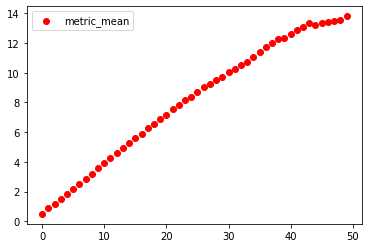

In [42]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)
plt.scatter(np.arange(len(metric_mean)), metric_mean, label="metric_mean", c='red')
#plt.plot(np.arange(len(time_displace)), time_displace, label="time_displace")
plt.legend()
plt.show()    

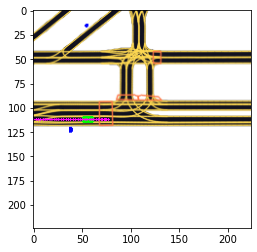

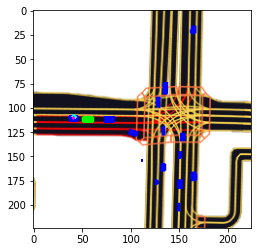

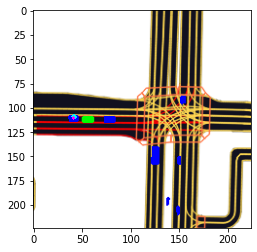

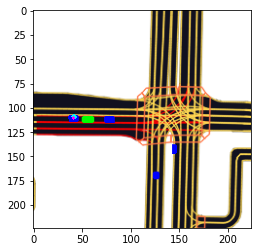

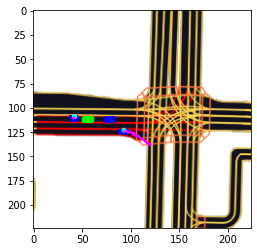

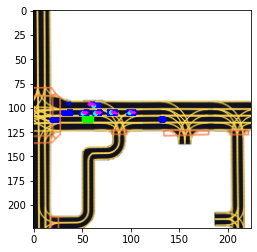

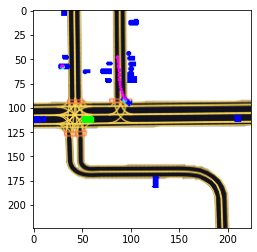

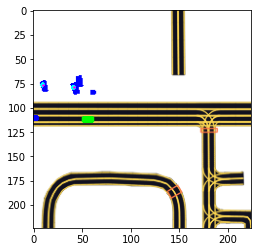

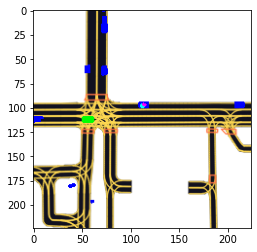

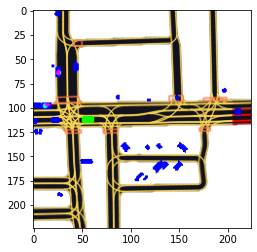

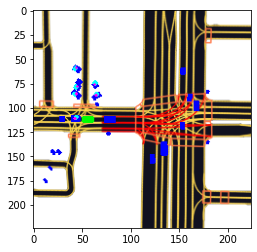

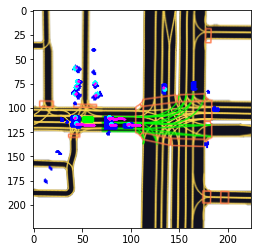

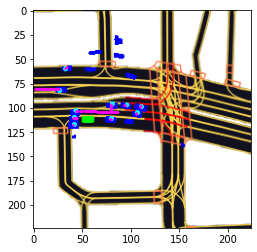

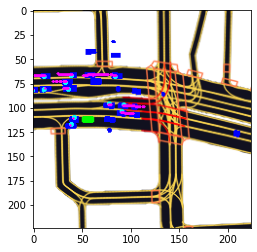

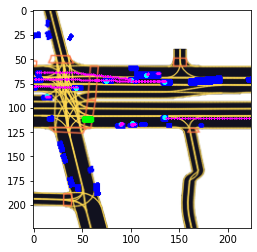

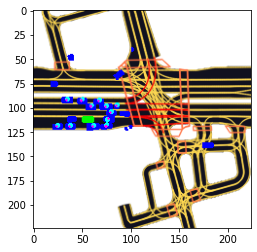

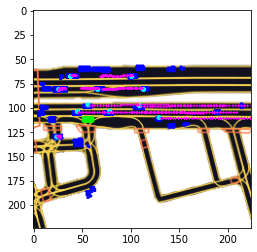

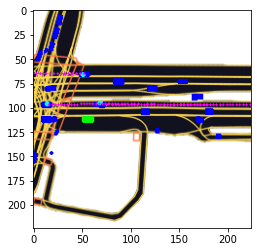

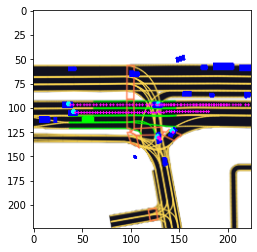

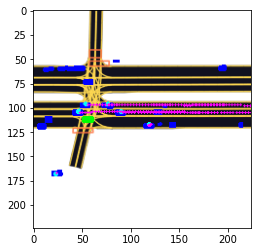

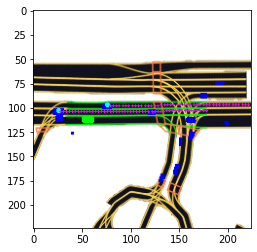

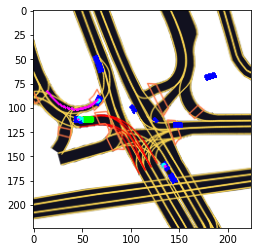

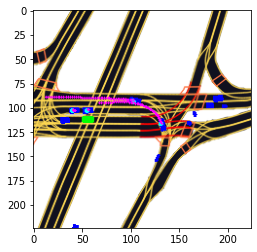

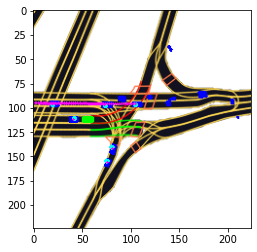

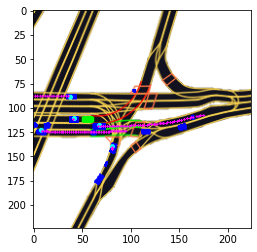

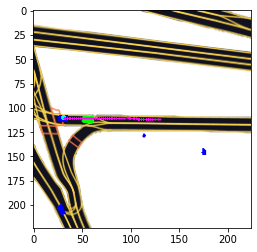

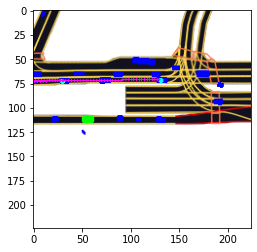

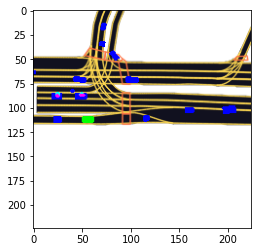

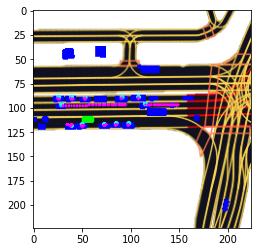

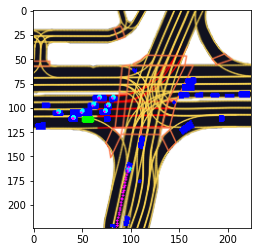

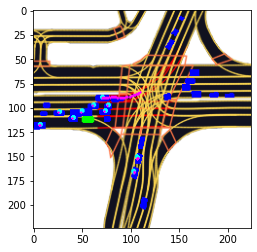

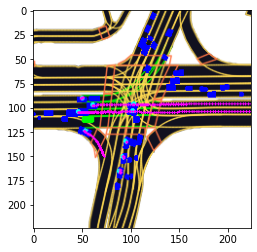

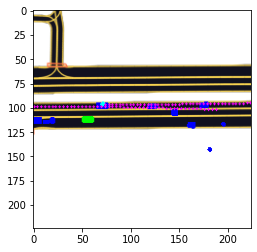

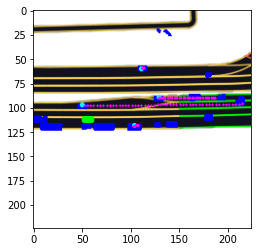

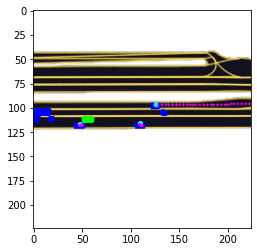

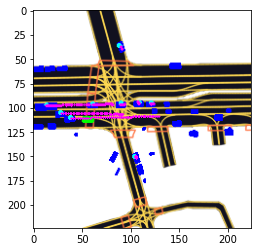

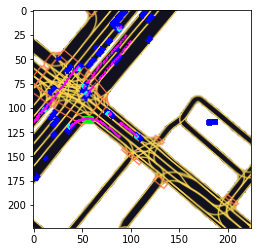

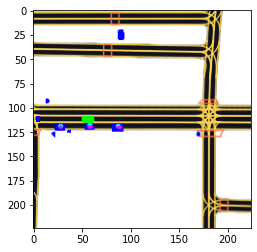

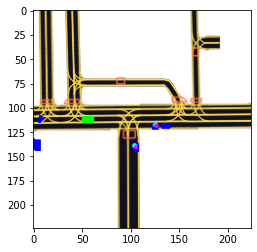

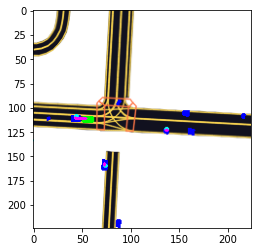

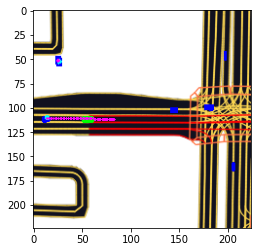

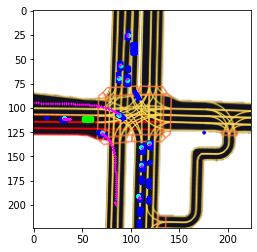

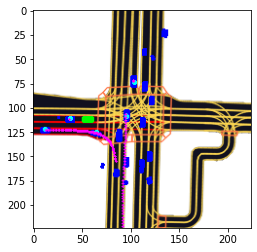

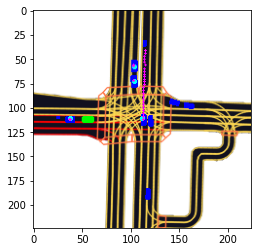

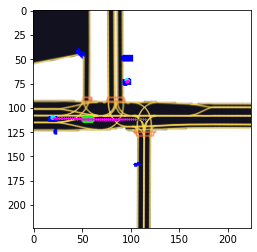

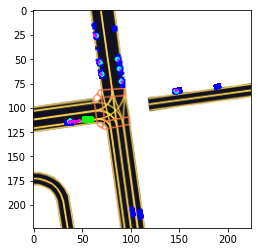

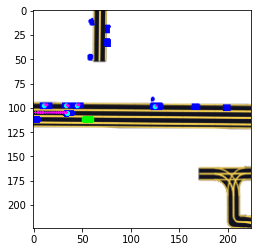

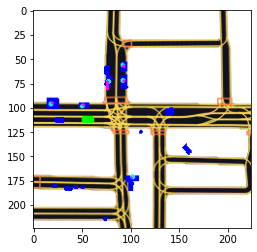

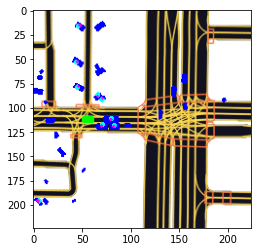

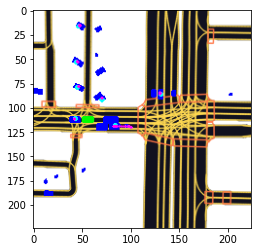

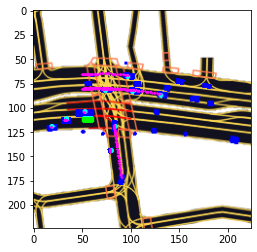

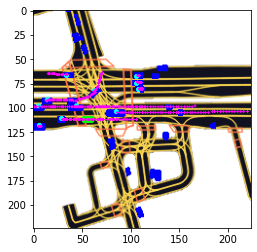

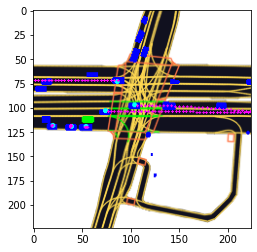

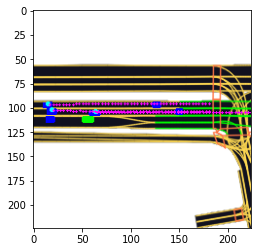

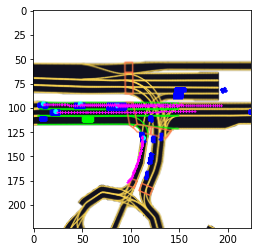

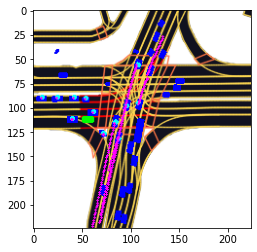

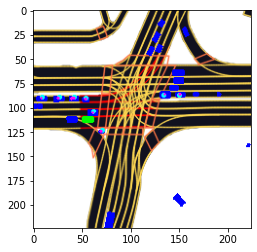

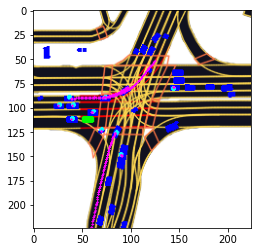

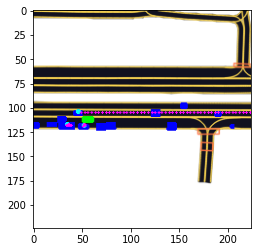

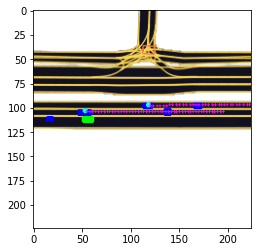

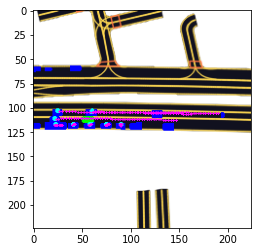

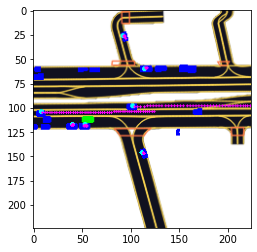

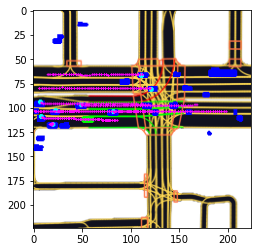

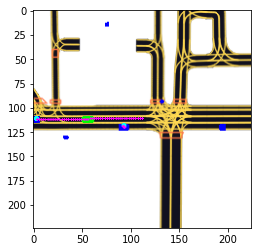

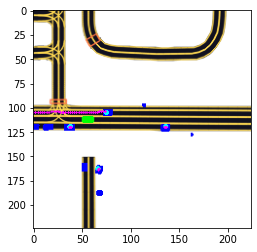

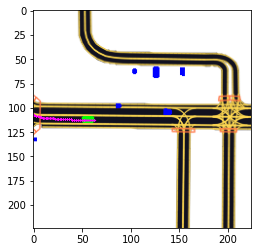

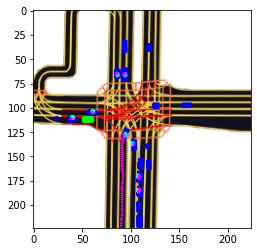

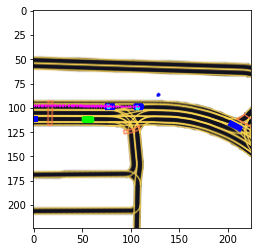

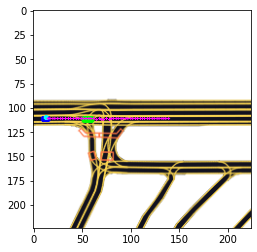

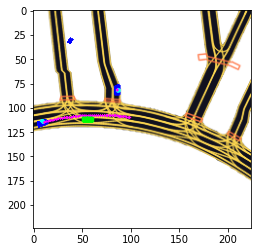

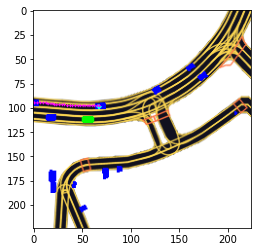

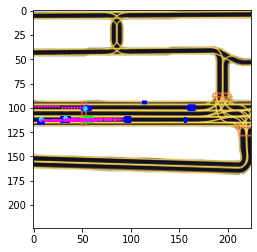

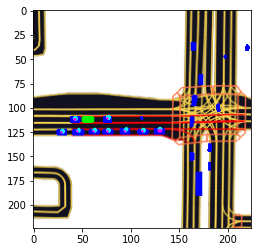

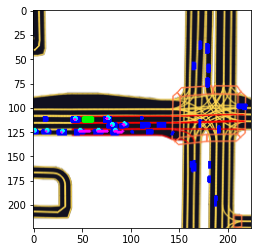

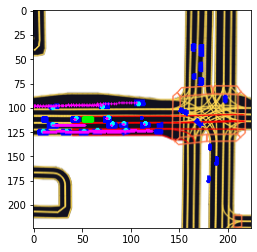

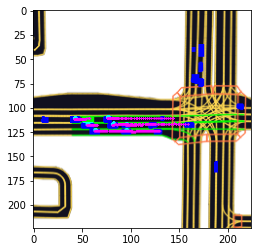

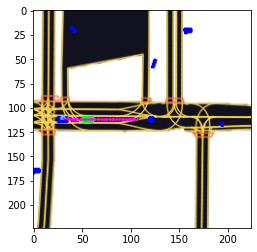

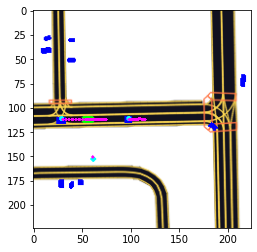

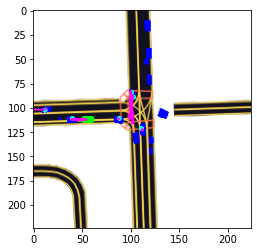

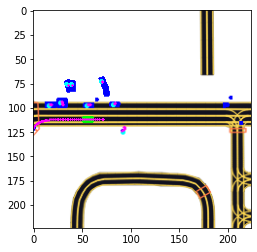

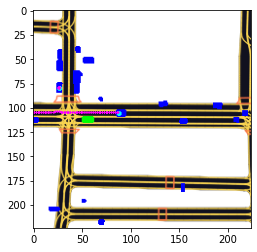

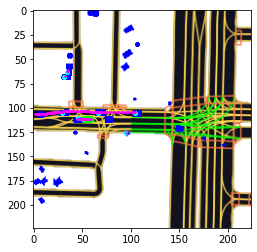

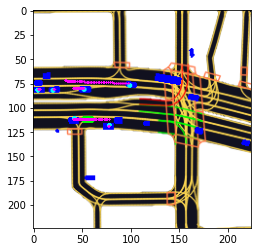

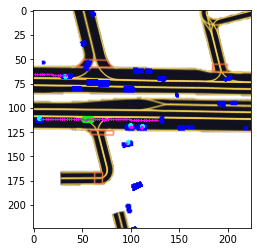

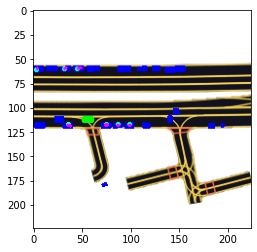

In [ ]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]
        out_net = data["image"].unsqueeze(0).to(device)
        #out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego)
    plt.show()

# Evaluation

Evaluation follows a slightly different protocol than training. When working with time series, we must be absolutely sure to avoid leaking the future in the data.

If we followed the same protocol of training, one could just read ahead in the `.zarr` and forge a perfect solution at run-time, even for a private test set.

As such, **the private test set for the competition has been "chopped" using the `chop_dataset` function**.

The result is that **each scene has been reduced to only 100 frames**, and **only valid agents in the 100th frame will be used to compute the metrics**. Because following frames in the scene have been chopped off, we can't just look ahead to get the future of those agents.

In this example, we simulate this pipeline by running `chop_dataset` on the validation set. The function stores:
- a new chopped `.zarr` dataset, in which each scene has only the first 100 frames;
- a numpy mask array where only valid agents in the 100th frame are True;
- a ground-truth file with the future coordinates of those agents;

Please note how the total number of frames is now equal to the number of scenes multipled by `num_frames_to_chop`. 

The remaining frames in the scene have been sucessfully chopped off from the data

### Storing Predictions
There is a small catch to be aware of when saving the model predictions. The output of the models are coordinates in `agent` space and we need to convert them into displacements in `world` space.

To do so, we first convert them back into the `world` space and we then subtract the centroid coordinates.

### Save results
After the model has predicted trajectories for our evaluation set, we can save them in a `csv` file.

During the competition, only the `.zarr` and the mask will be provided for the private test set evaluation.
Your solution is expected to generate a csv file which will be compared to the ground truth one on a separate server

In [ ]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

### Perform Evaluation
Pleae note that our metric supports multi-modal predictions (i.e. multiple predictions for a single GT trajectory). In that case, you will need to provide a confidence for each prediction (confidences must all be between 0 and 1 and sum to 1).

In this simple example we don't generate multiple trajectories, so we won't pass any confidences vector. Internally, the metric computation will assume a single trajectory with confidence equal to 1

### Visualise Results
We can also visualise some results from the ego (AV) point of view for those frames of interest (the 100th of each scene).

However, as we chopped off the future from the dataset **we must use the GT csv if we want to plot the future trajectories of the agents**
